# A notebook to to get true and predicted CTann and RUI for HRApop atlas datasets


## Goal

See [this GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/100)


## Import libraries


In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pprint import pprint
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

## Set global variables


In [2]:
hra_pop_version = "v0.10.3"

## Load data


In [3]:
# df_x = pd.read_csv("data/validation-v7-ctann-rui.csv")
df_x = pd.read_csv(
    "../../../hra-pop/output-data/v0.10.3/reports/atlas/validation-v7-x-axis.csv")
df_y = pd.read_csv(
    "../../../hra-pop/output-data/v0.10.3/reports/atlas/validation-v7-y-axis.csv")

## Prepare data for visualization and visualize


In [4]:
df_x

,sex,sample,rui_location,dataset,tool,modality,organ,organId,datasetVsRuiSim
0,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.950079
1,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.944614
2,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.934930
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952
...,...,...,...,...,...,...,...,...,...
902,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e21afc3c-3a7c-4717-90d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,spleen,UBERON:0002106,0.744703
903,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,1.000000
904,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.998475
905,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.913469


In [5]:
df_y

,sex,rui_location,dataset,tool,predicted_rui,similarity
0,Female,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.441815
1,Female,http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/731ade72-cdb7-4262-8be...,0.792217
2,Female,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.951883
3,Male,http://purl.org/ccf/1.5/886e391d-0151-46d3-8a5...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.957861
4,Male,http://purl.org/ccf/1.5/da28394d-789a-4fba-842...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.945847
...,...,...,...,...,...,...
927,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3...,0.925139
928,Male,http://purl.org/ccf/1.5/ca23f77c-a3cd-453f-bbe...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/1f414fc5-cb93-45b7-a1b...,0.855982
929,Male,http://purl.org/ccf/1.5/d662fd53-e925-4921-8d8...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,0.991318
930,Male,http://purl.org/ccf/1.5/df0b33f7-371a-47a4-a63...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/db35f27d-313f-4dd6-819...,0.911654


## Compute similarity scores for %AS


### Load atlas enriched dataset graph


In [6]:
ds_graph_path = f"../../../hra-pop/output-data/{
    hra_pop_version}/atlas-enriched-dataset-graph.jsonld"

with open(ds_graph_path) as f:
    graph = json.load(f)

### Define functions


In [7]:
def dict_to_vec(dict1: dict, dict2: dict):
    """Takes two dictionaries and returns a tuple of nornalized lists with values (0 if key not present)

    Args:
        dict1 (dict): dictionary 1
        dict2 (dict): dictionary 2
    Returns:
        result (tuple): a tuple with normalized lists
    """

    # initialize result
    dict1_list = []
    dict2_list = []

    # handle shared keys
    shared_keys = set(dict1['collisions'].keys()).intersection(
        dict2['collisions'].keys())
    
    for key in shared_keys:
        dict1_list.append(dict1['collisions'][key])
        dict2_list.append(dict2['collisions'][key])
    
    # handle not shared keys
    keys_in_dict1_not_in_dict2 = dict1.keys() - dict2.keys()
    for key in keys_in_dict1_not_in_dict2:
        dict1[key] = 0

    keys_in_dict2_not_in_dict1 = dict2.keys() - dict1.keys()
    for key in keys_in_dict2_not_in_dict1:
        dict1[key] = 0

    return (dict1_list, dict2_list)

def get_as_collision_items(iri: str):
    """A function to get AS collision items for an IRI (extraction site) and return a dictionary with AS UBERON ID and intersection percentage of the extraction site

    Args:
        iri (str): an IRI for an extraction site

    Returns:
        a dictionary with the IRI and a nested dictionary with collisions (ID and percentage) 
    """

    result = {
        
    }

    # loop through ds graph
    for donor in graph['@graph']:
        for sample in donor['samples']:
            current = sample['rui_location']
            if current['@id'] == iri:
                # print(current['all_collisions'])
                for collision_summary in current['all_collisions']:
                    for item in collision_summary['collisions']:
                        result[item['as_id']] = item['percentage']

    return result


def compute_cosine_similarity_by_as_percentage(iri_1: str, iri_2: str):
    """Takes two IRIs of extraction sites and returns the cosine similarity of their AS percentages

    Args:
                    iri_1 (str): An IRI for an extraction site
                    iri_2 (str): An IRI for an extraction site

Returns: 
                    similarity (float): A cosine similarity
    """

    # For debugging
    print()
    print(f"Now comparing {iri_1} and {iri_2}")

    # Get AS collision items as dict
    dict1 = get_as_collision_items(iri_1)
    dict2 = get_as_collision_items(iri_2)

    pprint(f"dict1: {dict1}")
    pprint(f"dict2: {dict2}")

    # Get a combined set of all keys from both dictionaries
    all_keys = set(dict1.keys()).union(dict2.keys())

    # Create the two lists of values
    values1 = [dict1.get(key, 0) for key in all_keys]
    values2 = [dict2.get(key, 0) for key in all_keys]

    print(values1)
    print(values2) 
 
    # Compute cosine similarity
    cosine_similarity_value = cosine_similarity([values1], [values2])
    print(f"Cosine Similarity: {cosine_similarity_value[0][0]}")
    
    return float(cosine_similarity_value[0][0])

### Loop through pairs of extraction sites (true and predicted) in validation and compute AS% similarity score


In [8]:
# Add a new column with the AS% cosine similarity
df_y['as_percentage_cosine_sim'] = df_y.apply(lambda row: compute_cosine_similarity_by_as_percentage(
    row['rui_location'], row['predicted_rui']), axis=1)

df_y

df_y.to_csv("output/df_y.csv")


Now comparing http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd and http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc
"dict1: {'http://purl.obolibrary.org/obo/UBERON_0002084': 0.914}"
("dict2: {'http://purl.obolibrary.org/obo/UBERON_0002094': 0.745, "
 "'http://purl.obolibrary.org/obo/UBERON_0002080': 0.119, "
 "'http://purl.org/sig/ont/fma/fma7267': 0.085, "
 "'http://purl.obolibrary.org/obo/UBERON_0002084': 0.478}")
[0, 0, 0.914, 0]
[0.119, 0.745, 0.478, 0.085]
Cosine Similarity: 0.5327927197064621

Now comparing http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919d-2e002eeae868 and http://purl.org/ccf/1.5/731ade72-cdb7-4262-8be1-859396820dfd
"dict1: {'http://purl.obolibrary.org/obo/UBERON_0004200': 1}"
"dict2: {'http://purl.obolibrary.org/obo/UBERON_0004200': 1}"
[1]
[1]
Cosine Similarity: 1.0

Now comparing http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864d-ace61789dff6 and http://purl.org/ccf/1.5/ca476545-5b98-476c-b2fd-1b8e1708faed
"dict1: {'http://purl.obolibrary.o

## Visualize


In [9]:
df_y

,sex,rui_location,dataset,tool,predicted_rui,similarity,as_percentage_cosine_sim
0,Female,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.441815,0.532793
1,Female,http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/731ade72-cdb7-4262-8be...,0.792217,1.000000
2,Female,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.951883,1.000000
3,Male,http://purl.org/ccf/1.5/886e391d-0151-46d3-8a5...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.957861,0.000000
4,Male,http://purl.org/ccf/1.5/da28394d-789a-4fba-842...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,0.945847,0.000000
...,...,...,...,...,...,...,...
927,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3...,0.925139,0.970143
928,Male,http://purl.org/ccf/1.5/ca23f77c-a3cd-453f-bbe...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/1f414fc5-cb93-45b7-a1b...,0.855982,0.000000
929,Male,http://purl.org/ccf/1.5/d662fd53-e925-4921-8d8...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,0.991318,0.000000
930,Male,http://purl.org/ccf/1.5/df0b33f7-371a-47a4-a63...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/db35f27d-313f-4dd6-819...,0.911654,1.000000


### Create combined DataFrame

In [10]:
# Merging on two columns (key1 and key2)
merged_df = pd.merge(df_x, df_y, on=['dataset', 'tool', 'rui_location', 'sex'], how='inner')

merged_df

,sex,sample,rui_location,dataset,tool,modality,organ,organId,datasetVsRuiSim,predicted_rui,similarity,as_percentage_cosine_sim
0,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.917636,0.532793
1,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.925033,0.000000
2,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,popv,sc_transcriptomics,heart,UBERON:0000948,0.941554,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.971689,0.000000
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.933921,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.978646,0.000000
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.474365,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.916703,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
893,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e21afc3c-3a7c-4717-90d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,spleen,UBERON:0002106,0.744703,http://purl.org/ccf/1.5/dc29aac6-af08-4fa4-9d5...,0.744706,0.999982
894,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,1.000000,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,1.000000,1.000000
895,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.998475,http://purl.org/ccf/1.5/cc08d64c-5d75-4995-b3b...,0.998475,1.000000
896,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.913469,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,0.913469,1.000000


### Build plot

Functions for making plots

In [11]:
def make_validation_scattergraph(x:float, y:float, palette:str, col:str, row:str, hue:str):
	"""A wrapper function around a seaborn FacetGrid to make multiple versions of the validation scattergraph

	Args:
			x (float): _description_
			y (float): _description_
			palette (str): _description_
			col (str): _description_
			row (str): _description_
			hue (str): _description_
	"""


	# Create a custom color palette
	custom_palette = sns.color_palette(palette)

	# Create FacetGrid
	g = sns.FacetGrid(
			merged_df,
			col=col,
			row=row,
			hue=hue,
			palette=custom_palette,
			height=5,
			aspect=1
	)

	# Set the style of the plot
	# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
	sns.set_style("whitegrid")

	# Create a scatter plot
	g.map(sns.scatterplot,x,y)

	# Add a legend
	g.add_legend()
	# Show the plot
	plt.show()

#### CTann vs RUI AS% similarity

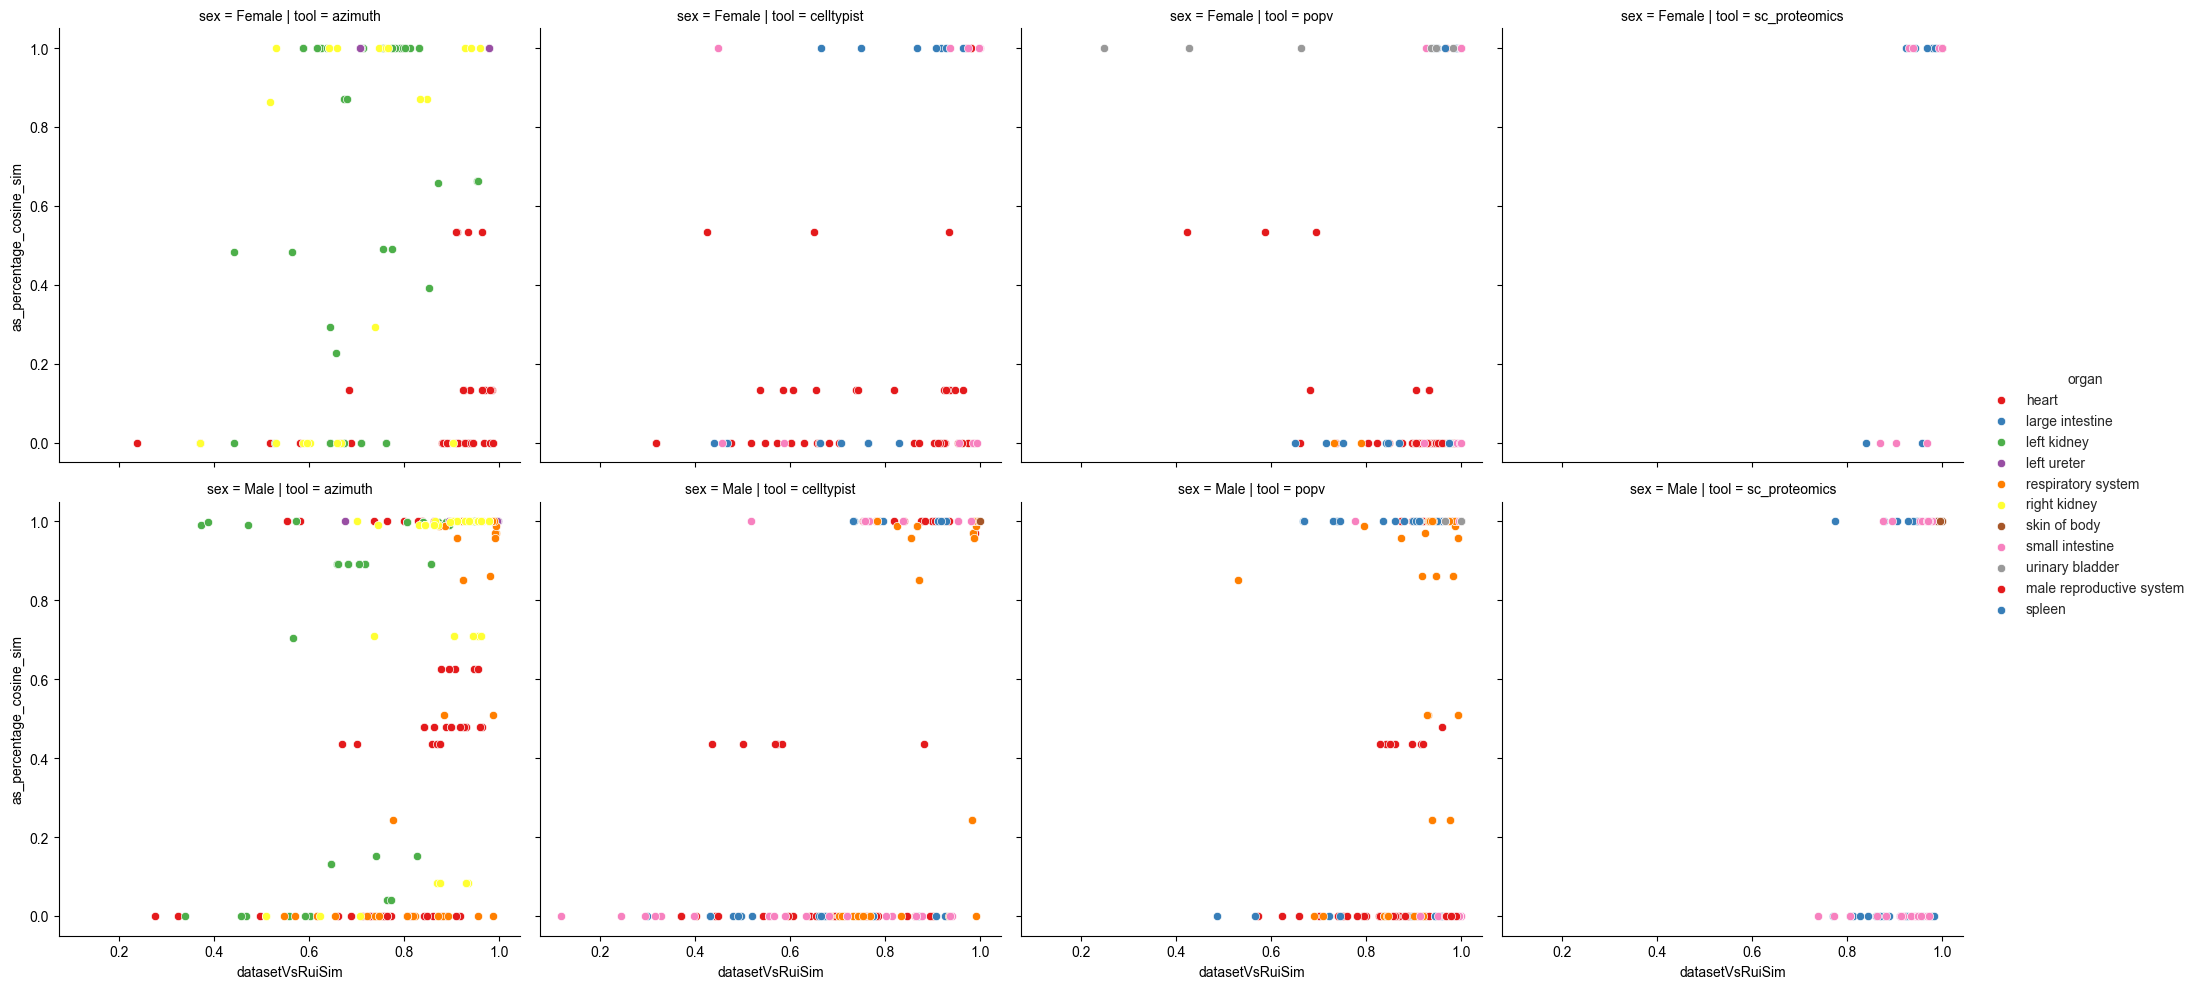

In [12]:
make_validation_scattergraph(
    "datasetVsRuiSim", "as_percentage_cosine_sim", "Set1", "tool", "sex", "organ")

#### CTann vs RUI cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary

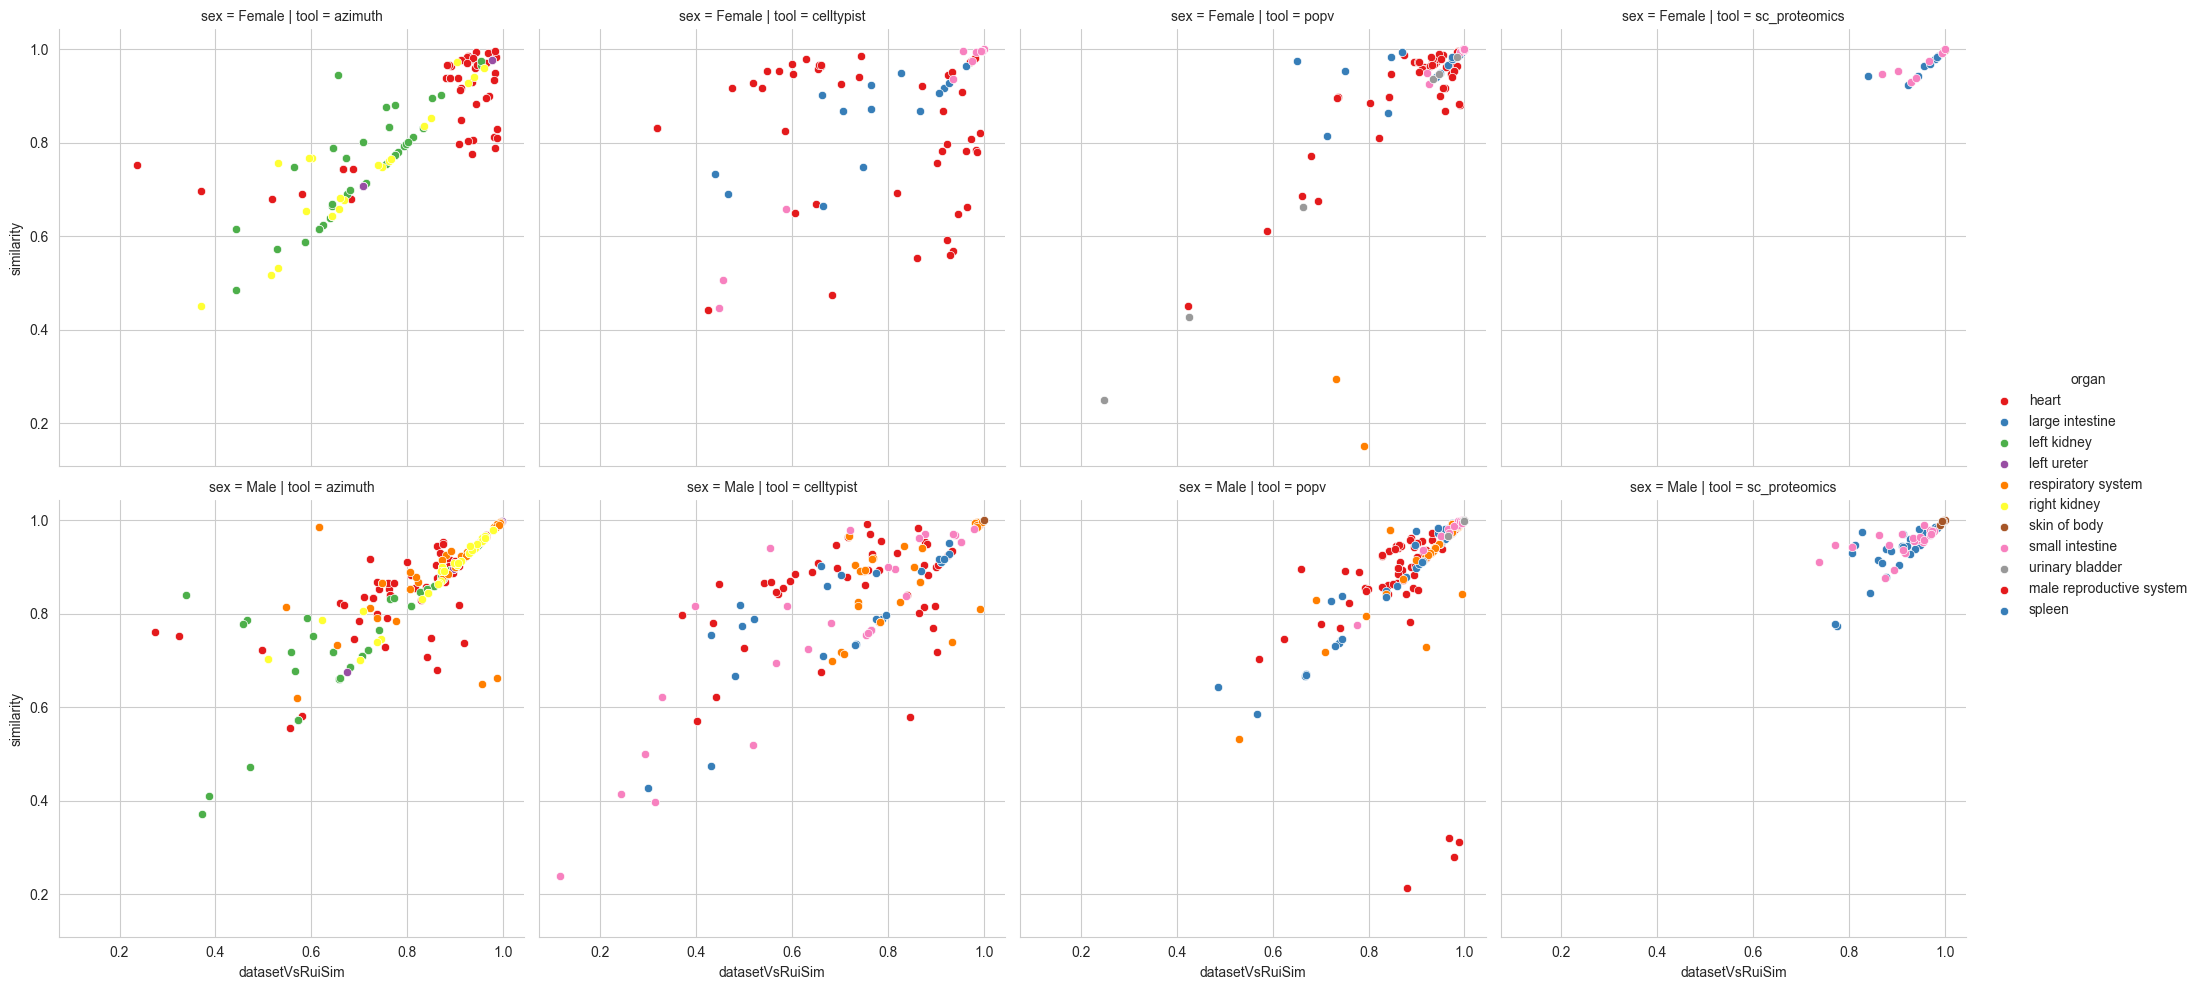

In [13]:
make_validation_scattergraph(
    "datasetVsRuiSim", "similarity", "Set1", "tool", "sex", "organ")

## Data dictionary


| Axis | Variable                                                  | Explanation                                                                                                                                 |
| ---- | --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| x    | datasetVsRuiSim                                           | CTann (x axis) Cosine sim between TRUE cell summary of input dataset and PREDICTED cell summary of input RUI location (as computed by US 1) |
| y    | similarity |  RUI (y axis) cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary             
| y (as) |  as_percentage_cosine_sim | cosine sim between AS% of TRUE and PREDICTED rui |                                                                                                                             |
